In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 11-47-20.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30 
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 11-47-20_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_02.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752191320.207037 23242336 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752191320.216105 23243414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752191320.222012 23243412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752191351.436785 23243419 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 10721
Frames with at least 1 hand detected: 8260
Detection rate: 77.05%


In [4]:
df = pd.read_csv("hand_landmarks_02.csv")

print("Shape:", df.shape)
df

Shape: (330414, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.0,Left,0,NaN,NaN,NaN,0
1,0,0.0,Left,1,NaN,NaN,NaN,0
2,0,0.0,Left,2,NaN,NaN,NaN,0
3,0,0.0,Left,3,NaN,NaN,NaN,0
4,0,0.0,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
330409,10720,178.7,Left,16,0.203577,0.418437,-0.005801,1
330410,10720,178.7,Left,17,0.194968,0.503024,-0.010540,1
330411,10720,178.7,Left,18,0.209846,0.474710,-0.010442,1
330412,10720,178.7,Left,19,0.219108,0.460747,-0.009410,1


In [5]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [6]:
df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,604,10.066667,Right,1,0.727684,0.706357,0.687763,0.675883,0.665725,0.682753,...,0.006073,0.001925,0.005431,0.004417,0.000251,-0.002313,-0.001736,-0.002182,-0.002451,-0.002128
1,605,10.083333,Left,1,0.725055,0.706236,0.688415,0.675552,0.665699,0.683211,...,-0.005087,-0.008956,0.001421,-0.002905,-0.007539,-0.009636,-0.002754,-0.005782,-0.007233,-0.007207
2,610,10.166667,Right,1,0.724475,0.706451,0.692406,0.683265,0.676058,0.685839,...,0.004834,0.001881,0.002045,0.002056,0.000370,-0.001168,-0.004580,-0.003486,-0.002456,-0.001859
3,612,10.200000,Left,1,0.729470,0.710737,0.693217,0.681434,0.672378,0.688736,...,-0.006654,-0.010539,-0.001328,-0.005130,-0.009017,-0.010941,-0.006283,-0.008745,-0.009288,-0.008824
4,618,10.300000,Left,1,0.726588,0.706251,0.688550,0.677318,0.668819,0.682988,...,0.002726,-0.001312,0.002225,0.000562,-0.003141,-0.005352,-0.004734,-0.006034,-0.006055,-0.005409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,10716,178.600000,Left,1,0.152515,0.144449,0.145446,0.146593,0.143516,0.167731,...,0.002098,0.002811,-0.006738,-0.006846,-0.007386,-0.008311,-0.011857,-0.012852,-0.013091,-0.013335
9744,10717,178.616667,Left,1,0.152520,0.144501,0.145576,0.146959,0.143106,0.167679,...,0.001460,0.001888,-0.006498,-0.006478,-0.006810,-0.007610,-0.011406,-0.012077,-0.011797,-0.011655
9745,10718,178.633333,Left,1,0.153682,0.143593,0.143109,0.145688,0.144081,0.162618,...,0.002635,0.004534,-0.006827,-0.007142,-0.006578,-0.006291,-0.011495,-0.012188,-0.011472,-0.010718
9746,10719,178.650000,Left,1,0.154163,0.143501,0.142555,0.144740,0.143617,0.163043,...,0.002092,0.003022,-0.006737,-0.006419,-0.006313,-0.006782,-0.011280,-0.011676,-0.010921,-0.010319


In [7]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,604,10.067,Right,1,0.727684,0.706357,0.687763,0.675883,0.665725,0.682753,...,0.006073,0.001925,0.005431,0.004417,0.000251,-0.002313,-0.001736,-0.002182,-0.002451,-0.002128
1,605,10.083,Left,1,0.725055,0.706236,0.688415,0.675552,0.665699,0.683211,...,-0.005087,-0.008956,0.001421,-0.002905,-0.007539,-0.009636,-0.002754,-0.005782,-0.007233,-0.007207
2,610,10.167,Right,1,0.724475,0.706451,0.692406,0.683265,0.676058,0.685839,...,0.004834,0.001881,0.002045,0.002056,0.000370,-0.001168,-0.004580,-0.003486,-0.002456,-0.001859
3,612,10.200,Left,1,0.729470,0.710737,0.693217,0.681434,0.672378,0.688736,...,-0.006654,-0.010539,-0.001328,-0.005130,-0.009017,-0.010941,-0.006283,-0.008745,-0.009288,-0.008824
4,618,10.300,Left,1,0.726588,0.706251,0.688550,0.677318,0.668819,0.682988,...,0.002726,-0.001312,0.002225,0.000562,-0.003141,-0.005352,-0.004734,-0.006034,-0.006055,-0.005409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,10716,178.600,Left,1,0.152515,0.144449,0.145446,0.146593,0.143516,0.167731,...,0.002098,0.002811,-0.006738,-0.006846,-0.007386,-0.008311,-0.011857,-0.012852,-0.013091,-0.013335
9744,10717,178.617,Left,1,0.152520,0.144501,0.145576,0.146959,0.143106,0.167679,...,0.001460,0.001888,-0.006498,-0.006478,-0.006810,-0.007610,-0.011406,-0.012077,-0.011797,-0.011655
9745,10718,178.633,Left,1,0.153682,0.143593,0.143109,0.145688,0.144081,0.162618,...,0.002635,0.004534,-0.006827,-0.007142,-0.006578,-0.006291,-0.011495,-0.012188,-0.011472,-0.010718
9746,10719,178.650,Left,1,0.154163,0.143501,0.142555,0.144740,0.143617,0.163043,...,0.002092,0.003022,-0.006737,-0.006419,-0.006313,-0.006782,-0.011280,-0.011676,-0.010921,-0.010319


In [8]:
df2 = pd.read_csv("hand_lable_02.csv")

print("Shape:", df.shape)
df2

Shape: (330414, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,other,NaN,START,0.000,D:/Data Science/UOB/DS_project/Full Study/02/2...,0,NaN,NaN
1,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,other,NaN,STOP,4.000,D:/Data Science/UOB/DS_project/Full Study/02/2...,240,NaN,NaN
2,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,lift,NaN,START,4.017,D:/Data Science/UOB/DS_project/Full Study/02/2...,241,NaN,NaN
3,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,lift,NaN,STOP,5.750,D:/Data Science/UOB/DS_project/Full Study/02/2...,345,NaN,NaN
4,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,hold,NaN,START,5.767,D:/Data Science/UOB/DS_project/Full Study/02/2...,346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,adjust,NaN,STOP,165.333,D:/Data Science/UOB/DS_project/Full Study/02/2...,9920,NaN,NaN
156,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,place,NaN,START,165.350,D:/Data Science/UOB/DS_project/Full Study/02/2...,9921,NaN,NaN
157,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,place,NaN,STOP,166.950,D:/Data Science/UOB/DS_project/Full Study/02/2...,10017,NaN,NaN
158,2,2025-07-07 16:14:09.910,NaN,178.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,178.683,60.0,NaN,other,NaN,START,166.967,D:/Data Science/UOB/DS_project/Full Study/02/2...,10018,NaN,NaN


In [9]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,0.000,4.000,0,240
1,lift,4.017,5.750,241,345
2,hold,5.767,35.450,346,2127
3,place,35.467,36.750,2128,2205
4,other,36.767,41.667,2206,2500
...,...,...,...,...,...
75,press,156.933,161.950,9416,9717
76,hold,161.967,162.483,9718,9749
77,adjust,162.500,165.333,9750,9920
78,place,165.350,166.950,9921,10017


In [10]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_42173/3184137910.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,604,10.067,Right,1,0.727684,0.706357,0.687763,0.675883,0.665725,0.682753,...,0.001925,0.005431,0.004417,0.000251,-0.002313,-0.001736,-0.002182,-0.002451,-0.002128,hold
1,605,10.083,Left,1,0.725055,0.706236,0.688415,0.675552,0.665699,0.683211,...,-0.008956,0.001421,-0.002905,-0.007539,-0.009636,-0.002754,-0.005782,-0.007233,-0.007207,hold
2,610,10.167,Right,1,0.724475,0.706451,0.692406,0.683265,0.676058,0.685839,...,0.001881,0.002045,0.002056,0.000370,-0.001168,-0.004580,-0.003486,-0.002456,-0.001859,hold
3,612,10.200,Left,1,0.729470,0.710737,0.693217,0.681434,0.672378,0.688736,...,-0.010539,-0.001328,-0.005130,-0.009017,-0.010941,-0.006283,-0.008745,-0.009288,-0.008824,hold
4,618,10.300,Left,1,0.726588,0.706251,0.688550,0.677318,0.668819,0.682988,...,-0.001312,0.002225,0.000562,-0.003141,-0.005352,-0.004734,-0.006034,-0.006055,-0.005409,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,10716,178.600,Left,1,0.152515,0.144449,0.145446,0.146593,0.143516,0.167731,...,0.002811,-0.006738,-0.006846,-0.007386,-0.008311,-0.011857,-0.012852,-0.013091,-0.013335,other
9744,10717,178.617,Left,1,0.152520,0.144501,0.145576,0.146959,0.143106,0.167679,...,0.001888,-0.006498,-0.006478,-0.006810,-0.007610,-0.011406,-0.012077,-0.011797,-0.011655,other
9745,10718,178.633,Left,1,0.153682,0.143593,0.143109,0.145688,0.144081,0.162618,...,0.004534,-0.006827,-0.007142,-0.006578,-0.006291,-0.011495,-0.012188,-0.011472,-0.010718,other
9746,10719,178.650,Left,1,0.154163,0.143501,0.142555,0.144740,0.143617,0.163043,...,0.003022,-0.006737,-0.006419,-0.006313,-0.006782,-0.011280,-0.011676,-0.010921,-0.010319,other


In [11]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    2746
hold      2576
press     1564
other     1136
adjust    1002
place      312
NaN        253
lift       159
Name: count, dtype: int64


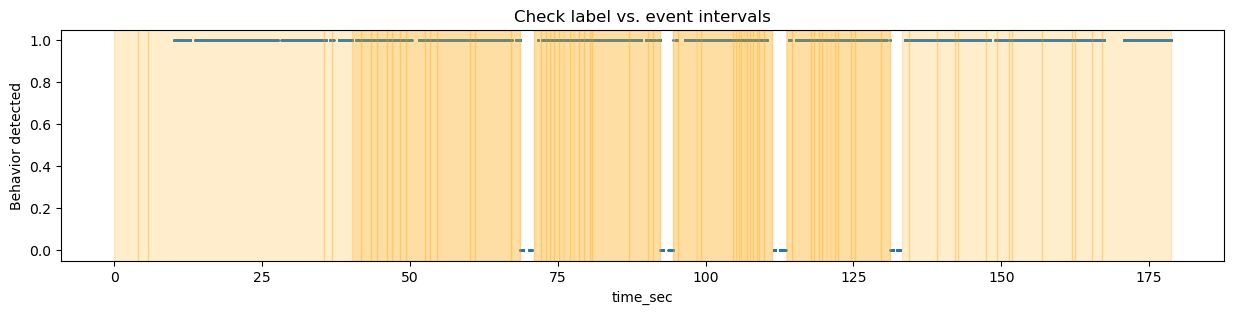

In [12]:

plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()


In [13]:
df_wide[(df_wide['time_sec'] <= 40.917)][['time_sec', 'behavior']]

,time_sec,behavior
0,10.067,hold
1,10.083,hold
2,10.167,hold
3,10.200,hold
4,10.300,hold
...,...,...
1506,40.167,other
1507,40.183,other
1508,40.200,other
1509,40.217,other


In [14]:
df_filtered = df_wide[df_wide['time_sec'] >= 40.917]

df_wide = df_filtered

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
1510,2455,40.917,Left,1,0.643807,0.648172,0.639969,0.616386,0.596580,0.631064,...,-0.009595,0.031453,0.020773,0.006211,-0.000549,0.037209,0.026997,0.017666,0.013031,lift
1511,2456,40.933,Left,1,0.644207,0.651175,0.644925,0.617024,0.594688,0.618925,...,-0.017684,0.030850,0.013802,-0.004069,-0.011284,0.034827,0.019432,0.007569,0.002268,lift
1512,2457,40.950,Left,1,0.648602,0.658030,0.649674,0.622058,0.600810,0.622604,...,-0.020759,0.022333,0.007332,-0.006872,-0.012383,0.027606,0.013707,0.003653,-0.000592,lift
1513,2458,40.967,Left,1,0.645477,0.654921,0.647057,0.621626,0.597783,0.620917,...,-0.032786,0.019785,0.000718,-0.014774,-0.020356,0.026120,0.009078,-0.002070,-0.006553,lift
1514,2459,40.983,Left,1,0.651253,0.661022,0.655235,0.628308,0.605572,0.620916,...,-0.045146,0.015112,-0.010079,-0.028302,-0.034408,0.019913,-0.001850,-0.015004,-0.020340,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,10716,178.600,Left,1,0.152515,0.144449,0.145446,0.146593,0.143516,0.167731,...,0.002811,-0.006738,-0.006846,-0.007386,-0.008311,-0.011857,-0.012852,-0.013091,-0.013335,other
9744,10717,178.617,Left,1,0.152520,0.144501,0.145576,0.146959,0.143106,0.167679,...,0.001888,-0.006498,-0.006478,-0.006810,-0.007610,-0.011406,-0.012077,-0.011797,-0.011655,other
9745,10718,178.633,Left,1,0.153682,0.143593,0.143109,0.145688,0.144081,0.162618,...,0.004534,-0.006827,-0.007142,-0.006578,-0.006291,-0.011495,-0.012188,-0.011472,-0.010718,other
9746,10719,178.650,Left,1,0.154163,0.143501,0.142555,0.144740,0.143617,0.163043,...,0.003022,-0.006737,-0.006419,-0.006313,-0.006782,-0.011280,-0.011676,-0.010921,-0.010319,other


In [15]:
df_wide['dataset_id'] = '02'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_42173/1887608429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide['dataset_id'] = '02'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
1510,02,2455,40.917,Left,1,0.643807,0.648172,0.639969,0.616386,0.596580,...,-0.009595,0.031453,0.020773,0.006211,-0.000549,0.037209,0.026997,0.017666,0.013031,lift
1511,02,2456,40.933,Left,1,0.644207,0.651175,0.644925,0.617024,0.594688,...,-0.017684,0.030850,0.013802,-0.004069,-0.011284,0.034827,0.019432,0.007569,0.002268,lift
1512,02,2457,40.950,Left,1,0.648602,0.658030,0.649674,0.622058,0.600810,...,-0.020759,0.022333,0.007332,-0.006872,-0.012383,0.027606,0.013707,0.003653,-0.000592,lift
1513,02,2458,40.967,Left,1,0.645477,0.654921,0.647057,0.621626,0.597783,...,-0.032786,0.019785,0.000718,-0.014774,-0.020356,0.026120,0.009078,-0.002070,-0.006553,lift
1514,02,2459,40.983,Left,1,0.651253,0.661022,0.655235,0.628308,0.605572,...,-0.045146,0.015112,-0.010079,-0.028302,-0.034408,0.019913,-0.001850,-0.015004,-0.020340,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,02,10716,178.600,Left,1,0.152515,0.144449,0.145446,0.146593,0.143516,...,0.002811,-0.006738,-0.006846,-0.007386,-0.008311,-0.011857,-0.012852,-0.013091,-0.013335,other
9744,02,10717,178.617,Left,1,0.152520,0.144501,0.145576,0.146959,0.143106,...,0.001888,-0.006498,-0.006478,-0.006810,-0.007610,-0.011406,-0.012077,-0.011797,-0.011655,other
9745,02,10718,178.633,Left,1,0.153682,0.143593,0.143109,0.145688,0.144081,...,0.004534,-0.006827,-0.007142,-0.006578,-0.006291,-0.011495,-0.012188,-0.011472,-0.010718,other
9746,02,10719,178.650,Left,1,0.154163,0.143501,0.142555,0.144740,0.143617,...,0.003022,-0.006737,-0.006419,-0.006313,-0.006782,-0.011280,-0.011676,-0.010921,-0.010319,other


In [16]:
df_wide.to_csv("handlandmark_wide_02.csv", index=False)